In [7]:
# Howard County Housing Indicators from FRED (Final Fixed Version)

from fredapi import Fred
import pandas as pd
import os

# 1Ô∏è Setup
API_KEY = "2ccf5b794d310f8cde1d30c463f8d2d4"  # for demo; move to env var later
fred = Fred(api_key=API_KEY)

# 2Ô∏è Monthly Realtor.com Series
price = fred.get_series('MEDLISPRI24027')      # Median Listing Price ($), monthly
active = fred.get_series('ACTLISCOU24027')     # Active Listing Count, monthly

monthly = (
    pd.DataFrame({
        'Date': pd.to_datetime(price.index),
        'Median_Listing_Price': price.values
    })
    .merge(active.rename('Active_Listings'),
           left_on='Date', right_index=True, how='outer')
    .sort_values('Date')
)

# 3Ô∏è Annual Series (Permits + Population)
permits_y = fred.get_series('BPPRIV024027')    # Building permits (annual)
pop_y = fred.get_series('MDHOWA0POP')          # Population (annual)

annual = pd.DataFrame({
    'Permits_Annual': permits_y,
    'Population_Annual': pop_y
})

# Convert to YEAR-END dates for alignment with month-end data
annual.index = pd.to_datetime(annual.index).to_period('Y').to_timestamp('M') + pd.offsets.MonthEnd(0)

# Reindex annual data to month-end and forward-fill
annual_m = (
    annual
    .reindex(pd.date_range(annual.index.min(), monthly['Date'].max(), freq='ME'))
    .ffill()
    .rename_axis('Date')
    .reset_index()
)

# Normalize all to month-end for proper merge
monthly['Date'] = pd.to_datetime(monthly['Date']).dt.to_period('M').dt.to_timestamp('M') + pd.offsets.MonthEnd(0)
annual_m['Date'] = pd.to_datetime(annual_m['Date']).dt.to_period('M').dt.to_timestamp('M') + pd.offsets.MonthEnd(0)

# 4Ô∏è Merge
df = monthly.merge(annual_m, on='Date', how='left')

# Fill forward to include latest 2025 months
df[['Permits_Annual', 'Population_Annual']] = df[['Permits_Annual', 'Population_Annual']].ffill()

# 5Ô∏è Save
df.to_csv('Howard_Housing_Indicators.csv', index=False)

print("‚úÖ Saved: Howard_Housing_Indicators.csv")
print(df.head(5))
print(df.tail(5))

‚úÖ Saved: Howard_Housing_Indicators.csv
        Date  Median_Listing_Price  Active_Listings  Permits_Annual  \
0 2016-07-31              499945.0           1189.0          2154.0   
1 2016-08-31              492448.0           1188.0          2154.0   
2 2016-09-30              497413.0           1187.0          2154.0   
3 2016-10-31              485495.0           1154.0          2154.0   
4 2016-11-30              474900.0           1045.0          2154.0   

   Population_Annual  
0            315.581  
1            315.581  
2            315.581  
3            315.581  
4            315.581  
          Date  Median_Listing_Price  Active_Listings  Permits_Annual  \
106 2025-05-31              695000.0            423.0           881.0   
107 2025-06-30              692450.0            449.0           881.0   
108 2025-07-31              680000.0            478.0           881.0   
109 2025-08-31              669950.0            511.0           881.0   
110 2025-09-30              6

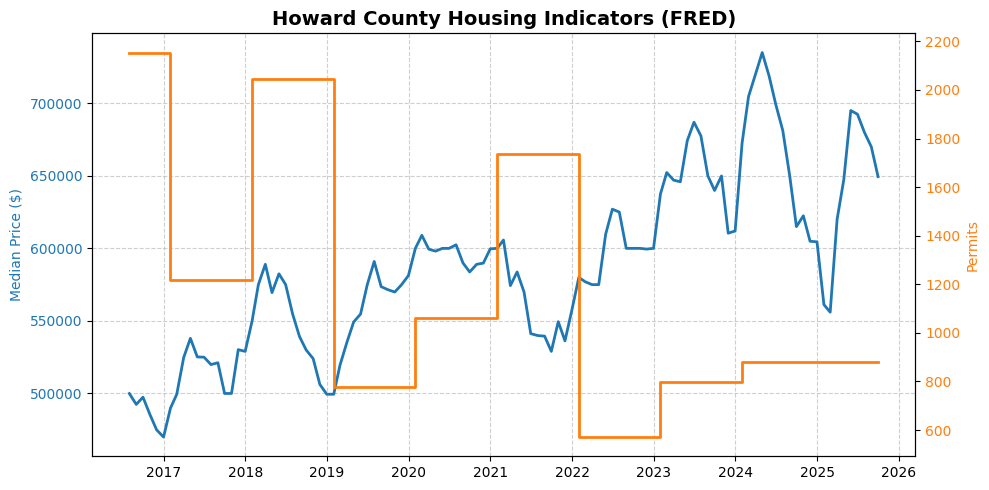

In [10]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,5))

# Plot median price (left axis)
ax1.plot(df['Date'], df['Median_Listing_Price'], color='tab:blue', linewidth=2, label='Median Listing Price ($)')
ax1.set_ylabel('Median Price ($)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot permits (right axis)
ax2 = ax1.twinx()
ax2.step(df['Date'], df['Permits_Annual'], color='tab:orange', where='post', linewidth=2, label='Building Permits (Annual)')
ax2.set_ylabel('Permits', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Titles and aesthetics
plt.title('Howard County Housing Indicators (FRED)', fontsize=14, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [11]:
# Compute a correlation between permits and listing price:
df[['Median_Listing_Price', 'Permits_Annual']].corr()


Median_Listing_Price  Permits_Annual
Median_Listing_Price              1.000000       -0.552068
Permits_Annual                   -0.552068        1.000000

In [12]:
#A utomate your FRED pipeline keeping Howard_Housing_Indicators.csv updated every month when new FRED data releases
from fredapi import Fred
import pandas as pd
import datetime as dt

def update_housing_data():
    API_KEY = "2ccf5b794d310f8cde1d30c463f8d2d4"
    fred = Fred(api_key=API_KEY)

    # Monthly series
    price = fred.get_series('MEDLISPRI24027')
    active = fred.get_series('ACTLISCOU24027')
    monthly = (
        pd.DataFrame({
            'Date': pd.to_datetime(price.index),
            'Median_Listing_Price': price.values
        })
        .merge(active.rename('Active_Listings'),
               left_on='Date', right_index=True, how='outer')
        .sort_values('Date')
    )

    # Annual series
    permits_y = fred.get_series('BPPRIV024027')
    pop_y = fred.get_series('MDHOWA0POP')
    annual = pd.DataFrame({'Permits_Annual': permits_y, 'Population_Annual': pop_y})

    annual.index = pd.to_datetime(annual.index).to_period('Y').to_timestamp('M') + pd.offsets.MonthEnd(0)
    annual_m = (
        annual
        .reindex(pd.date_range(annual.index.min(), monthly['Date'].max(), freq='ME'))
        .ffill()
        .rename_axis('Date')
        .reset_index()
    )

    monthly['Date'] = pd.to_datetime(monthly['Date']).dt.to_period('M').dt.to_timestamp('M') + pd.offsets.MonthEnd(0)
    annual_m['Date'] = pd.to_datetime(annual_m['Date']).dt.to_period('M').dt.to_timestamp('M') + pd.offsets.MonthEnd(0)

    df = monthly.merge(annual_m, on='Date', how='left')
    df[['Permits_Annual', 'Population_Annual']] = df[['Permits_Annual', 'Population_Annual']].ffill()

    df.to_csv('Howard_Housing_Indicators.csv', index=False)
    print(f"‚úÖ Updated on {dt.date.today()} ‚Äî Howard_Housing_Indicators.csv saved ({len(df)} rows).")

if __name__ == "__main__":
    update_housing_data()

‚úÖ Updated on 2025-10-29 ‚Äî Howard_Housing_Indicators.csv saved (111 rows).


# Automate with Windows Task Scheduler (or cron on Mac/Linux)
1. Open Task Scheduler ‚Üí ‚ÄúCreate Basic Task‚Äù.
2. Name it Update_Housing_Data.
3. Choose Monthly ‚Üí pick Day 3 (FRED updates early each month).
4. Action ‚Üí ‚ÄúStart a program‚Äù.
5. Program/script:
   python... Add arguments: "C:\path\to\update_housing_data.py"
6. Save ‚Üí Done

# On macOS / üêß Linux:
1. Open Terminal and type: crontab -e
   Then add 0 8 3 * * /usr/bin/python3 /path/to/update_housing_data.py >> /path/to/update_log.txt 2>&1

   This runs it at 8:00 AM on the 3rd day of each month.

# Optional Add an Email or Slack Notification
You can send yourself a message each time it runs:

In [14]:
import smtplib
from email.mime.text import MIMEText

def send_notification():
    msg = MIMEText("Howard County housing dataset has been updated successfully.")
    msg['Subject'] = "‚úÖ FRED Housing Data Updated"
    msg['From'] = "you@example.com"
    msg['To'] = "you@example.com"
    s = smtplib.SMTP('smtp.gmail.com', 587)
    s.starttls()
    s.login("you@example.com", "your_app_password")
    s.send_message(msg)
    s.quit()

In [ ]:
# Call it right after saving the CSV:
send_notification()